In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
df = pd.read_csv("data/steam.csv")
df.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


#### 0. Summary
First, let's summarize the dataset

In [3]:
df.describe()

,appid,english,required_age,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price
count,2.707500e+04,27075.000000,27075.000000,27075.000000,2.707500e+04,27075.000000,27075.000000,27075.00000,27075.000000
mean,5.962035e+05,0.981127,0.354903,45.248864,1.000559e+03,211.027147,149.804949,146.05603,6.078193
std,2.508942e+05,0.136081,2.406044,352.670281,1.898872e+04,4284.938531,1827.038141,2353.88008,7.874922
min,1.000000e+01,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.00000,0.000000
25%,4.012300e+05,1.000000,0.000000,0.000000,6.000000e+00,2.000000,0.000000,0.00000,1.690000
50%,5.990700e+05,1.000000,0.000000,7.000000,2.400000e+01,9.000000,0.000000,0.00000,3.990000
75%,7.987600e+05,1.000000,0.000000,23.000000,1.260000e+02,42.000000,0.000000,0.00000,7.190000
max,1.069460e+06,1.000000,18.000000,9821.000000,2.644404e+06,487076.000000,190625.000000,190625.00000,421.990000


In [4]:
df.isna().sum()

appid               0
name                0
release_date        0
english             0
developer           0
publisher           0
platforms           0
required_age        0
categories          0
genres              0
steamspy_tags       0
achievements        0
positive_ratings    0
negative_ratings    0
average_playtime    0
median_playtime     0
owners              0
price               0
dtype: int64

Great, there is no missing data.

#### 1. Split tags
Notice that, items in `platforms`, `categories`, `genres`, and `steamspy_tags` are list of tags. Let's count the number of unique tags in `platforms`, `categories`, `genres`, and `steamspy_tags` and the number of occurrences of each of these tags

In [5]:
def count_uniques(data, column_name):
    """Count the number of unique tags and the number of occurrences of each of these tag
    
    Parameters: 
    data: A Pandas dataframe
    column_name: The target column name
    
    Returns:
    dictionary: A dictionary (tag -> occurences)
    """
    res = {}
    
    for index, item in data[column_name].items():
        for tag in item.split(';'):
            if tag in res:
                # If this tag already existed in the dictionary, increase the count
                res[tag] += 1
            else:
                # Else add the tag in the dictionary with count 1
                res[tag] = 1
        
    return res

In [6]:
def generate_uniques(data, column_name, merge_map=None):
    """Generate a binary column for each tag in the target column
    
    Parameters: 
    data: A Pandas dataframe
    column_name: The target column name
    merge_map: An optional dictionary where 
        tag 'key' should be considered identical to tag 'value'
        and only one binary column of tag 'value' should be generated
    
    Returns:
    Pandas DataFrame: An updated dataset with additional binary columns
    """
    
    column_list = list(count_uniques(data, column_name).keys())
    # If merge-map exists, new column_list are merge_map's values
    if merge_map != None:
        column_list = list(merge_map.values())
    
    for column in column_list:
        # Initiate a new '0' column for each tag 
        data[column_name + '_' + column] = 0
    
    # Fill in these new columns
    for index, item in data[column_name].items():
        for tag in item.split(';'):
            if merge_map != None:
                if tag in merge_map:
                    # If merge_map exists and tag is in merge_map
                    data.loc[index, column_name + '_' + merge_map[tag]] = 1
                # Else ignore
            else:
                # If merge_map does not exist
                data.loc[index, column_name + '_' + tag] = 1
            
    return data

##### a) `platforms`

In [7]:
count_uniques_platforms = count_uniques(df, "platforms")
print("Number of unique tags:", len(count_uniques_platforms.keys()))

Number of unique tags: 3


<AxesSubplot:title={'center':'platforms'}>

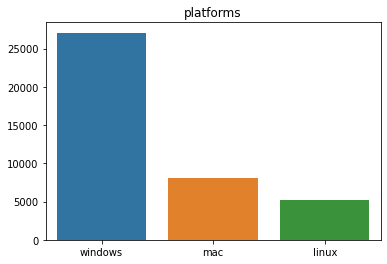

In [8]:
plt.title("platforms")
sns.barplot(list(count_uniques_platforms.keys()), list(count_uniques_platforms.values()))

In [9]:
df = generate_uniques(df, "platforms")

In [10]:
# Check if the generated columns are correct
for tag in count_uniques_platforms.keys():
    assert(count_uniques_platforms[tag] == df["platforms_" + tag].sum())

##### b) `categories`

In [11]:
count_uniques_categories = count_uniques(df, "categories")
count_uniques_categories = {k: v for k, v in sorted(count_uniques_categories.items(), key=lambda item: item[1], reverse=True)}
print("Number of unique tags:", len(count_uniques_categories.keys()))

Number of unique tags: 29


<AxesSubplot:title={'center':'categories'}>

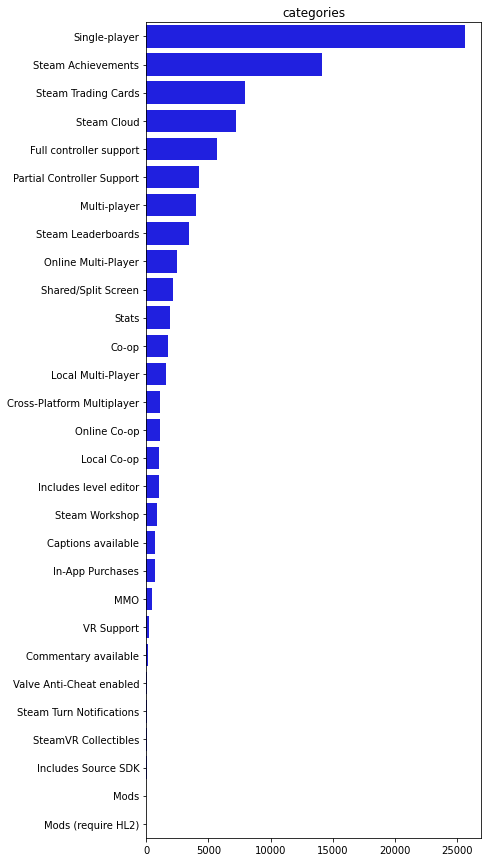

In [12]:
f, ax = plt.subplots(figsize=(6, 15))
plt.title("categories")
sns.barplot(list(count_uniques_categories.values()), list(count_uniques_categories.keys()), color='b', ax=ax, orient='h')

Here, we only want to know whether the game is `multiplayer`, `singleplayer`, `co-op` or has `in-app purchases`, `mods`, `controller support`, `vr support`. Let's create a merge map:

In [13]:
merge_map_categories = {
    'Mods (require HL2)': 'mod', 
    'Mods': 'mod', 
    'Includes Source SDK': 'mod', 
    'SteamVR Collectibles': 'vr_support', 
    'VR Support': 'vr_support', 
    'MMO': 'multiplayer', 
    'In-App Purchases': 'in_app_purchase', 
    'Steam Workshop': 'mod', 
    'Includes level editor': 'mod', 
    'Local Co-op': 'co_op', 
    'Online Co-op': 'co_op', 
    'Cross-Platform Multiplayer': 'multiplayer', 
    'Local Multi-Player': 'multiplayer', 
    'Co-op': 'co_op', 
    'Shared/Split Screen': 'co_op', 
    'Online Multi-Player': 'multiplayer', 
    'Multi-player': 'multiplayer', 
    'Partial Controller Support': 'controller_support', 
    'Full controller support': 'controller_support', 
    'Single-player': 'singleplayer'
}

In [14]:
df = generate_uniques(df, "categories", merge_map_categories)

In [15]:
df.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,platforms_windows,platforms_mac,platforms_linux,categories_mod,categories_vr_support,categories_multiplayer,categories_in_app_purchase,categories_co_op,categories_controller_support,categories_singleplayer
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19,1,1,1,0,0,1,0,0,0,0
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99,1,1,1,0,0,1,0,0,0,0
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99,1,1,1,0,0,1,0,0,0,0
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99,1,1,1,0,0,1,0,0,0,0
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99,1,1,1,0,0,1,0,0,0,1


##### c) `genres`

In [16]:
count_uniques_genres = count_uniques(df, "genres")
count_uniques_genres = {k: v for k, v in sorted(count_uniques_genres.items(), key=lambda item: item[1], reverse=True)}
print("Number of unique tags:", len(count_uniques_genres.keys()))

Number of unique tags: 29


<AxesSubplot:title={'center':'genres'}>

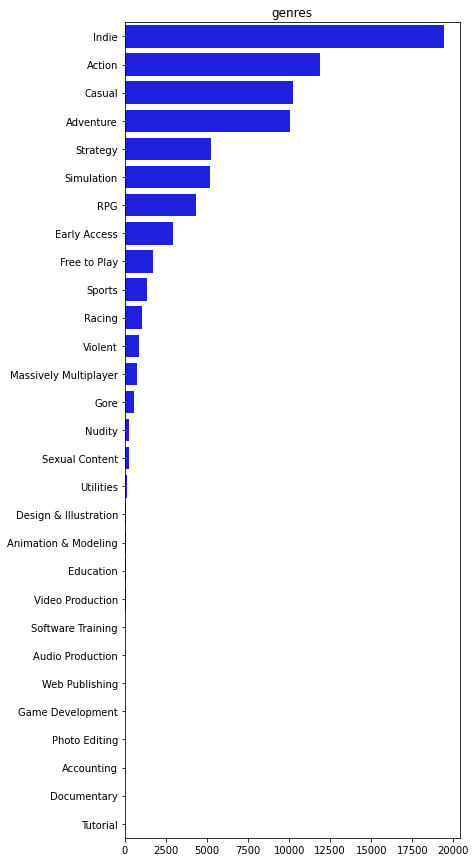

In [17]:
f, ax = plt.subplots(figsize=(6, 15))
plt.title("genres")
sns.barplot(list(count_uniques_genres.values()), list(count_uniques_genres.keys()), color='b', ax=ax, orient='h')

`Free to play` and `Early Access` are technically not game genres but they may held some interesting information. We would also like to extract top 10 genres to binary columns. Let's have another merge-map

In [18]:
merge_map_genres = { 
    'Massively Multiplayer': 'massively_multiplayer', 
    'Racing': 'racing', 
    'Sports': 'sport', 
    'Free to Play': 'free_to_play', 
    'Early Access': 'early_access', 
    'RPG': 'rpg', 
    'Simulation': 'simulation', 
    'Strategy': 'strategy', 
    'Adventure': 'adventure', 
    'Casual': 'casual', 
    'Action': 'action', 
    'Indie': 'indie'
}

In [19]:
df = generate_uniques(df, "genres", merge_map_genres)

In [20]:
df.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price,platforms_windows,platforms_mac,platforms_linux,categories_mod,categories_vr_support,categories_multiplayer,categories_in_app_purchase,categories_co_op,categories_controller_support,categories_singleplayer,genres_massively_multiplayer,genres_racing,genres_sport,genres_free_to_play,genres_early_access,genres_rpg,genres_simulation,genres_strategy,genres_adventure,genres_casual,genres_action,genres_indie
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99,1,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


##### d) `steamspy_tags`

In [21]:
count_uniques_steamspy_tags = count_uniques(df, "steamspy_tags")
count_uniques_steamspy_tags = {k: v for k, v in sorted(count_uniques_steamspy_tags.items(), key=lambda item: item[1], reverse=True)}
print("Number of unique tags:", len(count_uniques_steamspy_tags.keys()))

Number of unique tags: 339


There are too many tags to consider. We've already have the necessary genre tags from `genres`. Let's just see what are the top 20 `steamspy_tags` tags.

<AxesSubplot:title={'center':'top 20 steamspy_tags'}>

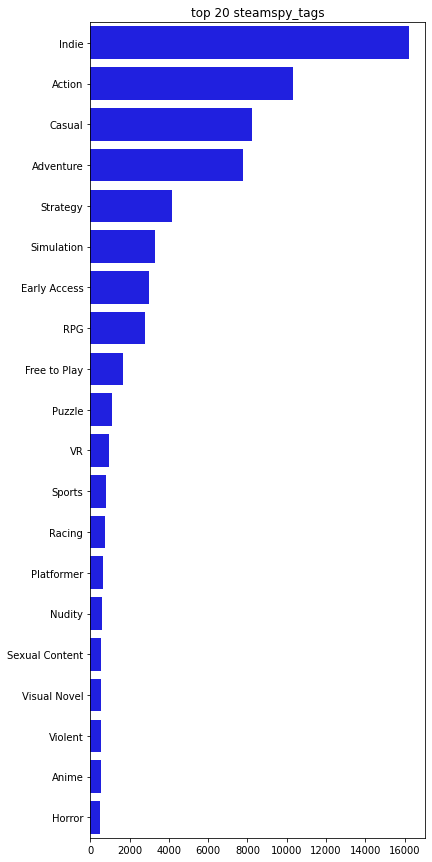

In [22]:
f, ax = plt.subplots(figsize=(6, 15))
plt.title("top 20 steamspy_tags")
sns.barplot(list(count_uniques_steamspy_tags.values())[:20], list(count_uniques_steamspy_tags.keys())[:20], color='b', ax=ax, orient='h')

These are very similar to the `genres` tags distribution, which re-confirm that we can safely drop this feature.

In [23]:
# Dropping all processed columns
df = df.drop(columns=["platforms", "categories", "genres", "steamspy_tags"])

#### 2. Ranges
##### a) `Owners`
Next, because the number of owners are actually represented by ranges, we shall split `owners` into `min_owners`, `max_owners` and `approx_owners` which equals to (`min_owners` + `max_owners`) / 2

In [24]:
# Extract the range of owners by splitting owners strings
owners_range = df["owners"].str.split('-', n=1, expand=True)

In [25]:
df["min_owners"] = owners_range[0].astype(int)
df["max_owners"] = owners_range[1].astype(int)
df["approx_owners"] = (df["min_owners"] + df["max_owners"]) / 2

In [26]:
df = df.drop(columns="owners")

##### b) Total playtime
From `owners` and `average_playtime`, we can extract `min_total_playtime`, `max_total_playtime` and `approx_total_playtime`

In [27]:
df["min_total_playtime"] = df["min_owners"] * df["average_playtime"]
df["max_total_playtime"] = df["max_owners"] * df["average_playtime"]
df["approx_total_playtime"] = df["approx_owners"] * df["average_playtime"]

##### c) Revenue
Similarly, from `price` and `owners`, we can extract `min_revenue`, `max_revenue` and `approx_revenue`. Note that this does not include revenue from selling in-game items and DLCs.

In [28]:
df["min_revenue"] = df["min_owners"] * df["price"]
df["max_revenue"] = df["max_owners"] * df["price"]
df["approx_revenue"] = df["approx_owners"] * df["price"]

In [29]:
df.head()

,appid,name,release_date,english,developer,publisher,required_age,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price,platforms_windows,platforms_mac,platforms_linux,categories_mod,categories_vr_support,categories_multiplayer,categories_in_app_purchase,categories_co_op,categories_controller_support,categories_singleplayer,genres_massively_multiplayer,genres_racing,genres_sport,genres_free_to_play,genres_early_access,genres_rpg,genres_simulation,genres_strategy,genres_adventure,genres_casual,genres_action,genres_indie,min_owners,max_owners,approx_owners,min_total_playtime,max_total_playtime,approx_total_playtime,min_revenue,max_revenue,approx_revenue
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,0,0,124534,3339,17612,317,7.19,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,10000000,20000000,15000000.0,176120000000,352240000000,2.641800e+11,71900000.0,143800000.0,107850000.0
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,0,0,3318,633,277,62,3.99,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,5000000,10000000,7500000.0,1385000000,2770000000,2.077500e+09,19950000.0,39900000.0,29925000.0
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,0,0,3416,398,187,34,3.99,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,5000000,10000000,7500000.0,935000000,1870000000,1.402500e+09,19950000.0,39900000.0,29925000.0
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,0,0,1273,267,258,184,3.99,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,5000000,10000000,7500000.0,1290000000,2580000000,1.935000e+09,19950000.0,39900000.0,29925000.0
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,0,0,5250,288,624,415,3.99,1,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,5000000,10000000,7500000.0,3120000000,6240000000,4.680000e+09,19950000.0,39900000.0,29925000.0


#### 3. Datetime
Finally, let's extract day, month and year from `release_date`, so that we will have numerical values to work with

In [30]:
release_date = pd.to_datetime(df["release_date"])

In [31]:
df["release_day"] = release_date.dt.day

In [32]:
df["release_month"] = release_date.dt.month

In [33]:
df["release_year"] = release_date.dt.year

In [34]:
df = df.drop(columns="release_date")
df.head()

,appid,name,english,developer,publisher,required_age,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,price,platforms_windows,platforms_mac,platforms_linux,categories_mod,categories_vr_support,categories_multiplayer,categories_in_app_purchase,categories_co_op,categories_controller_support,categories_singleplayer,genres_massively_multiplayer,genres_racing,genres_sport,genres_free_to_play,genres_early_access,genres_rpg,genres_simulation,genres_strategy,genres_adventure,genres_casual,genres_action,genres_indie,min_owners,max_owners,approx_owners,min_total_playtime,max_total_playtime,approx_total_playtime,min_revenue,max_revenue,approx_revenue,release_day,release_month,release_year
0,10,Counter-Strike,1,Valve,Valve,0,0,124534,3339,17612,317,7.19,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,10000000,20000000,15000000.0,176120000000,352240000000,2.641800e+11,71900000.0,143800000.0,107850000.0,1,11,2000
1,20,Team Fortress Classic,1,Valve,Valve,0,0,3318,633,277,62,3.99,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,5000000,10000000,7500000.0,1385000000,2770000000,2.077500e+09,19950000.0,39900000.0,29925000.0,1,4,1999
2,30,Day of Defeat,1,Valve,Valve,0,0,3416,398,187,34,3.99,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,5000000,10000000,7500000.0,935000000,1870000000,1.402500e+09,19950000.0,39900000.0,29925000.0,1,5,2003
3,40,Deathmatch Classic,1,Valve,Valve,0,0,1273,267,258,184,3.99,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,5000000,10000000,7500000.0,1290000000,2580000000,1.935000e+09,19950000.0,39900000.0,29925000.0,1,6,2001
4,50,Half-Life: Opposing Force,1,Gearbox Software,Valve,0,0,5250,288,624,415,3.99,1,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,5000000,10000000,7500000.0,3120000000,6240000000,4.680000e+09,19950000.0,39900000.0,29925000.0,1,11,1999


In [35]:
df.to_csv("data/processed_steam.csv", index=False)